<a href="https://colab.research.google.com/github/naenumtou/creditrisk/blob/main/SMOTESampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Set auto reload
%reload_ext autoreload
%autoreload 2

In [2]:
# Install library
!pip install -q imbalanced-learn

In [3]:
# Change directory to Google Drive
%cd /content/drive/My Drive/Colab Notebooks/BScore

/content/drive/My Drive/Colab Notebooks/BScore


In [4]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from collections import Counter
from imblearn.over_sampling import SMOTENC

# Config
%config InlineBackend.figure_format = 'retina' #Retina display
plt.style.use('seaborn-deep') #Plot style
pd.set_option('display.max_columns', None) #Max column width

In [5]:
# Import training data
df = pd.read_parquet(
    'trainTransaction.parquet',
    engine = 'pyarrow'
)
print(f'Total rows: {df.shape[0]}\nTotal columns: {df.shape[1]}')

Total rows: 292851
Total columns: 337


### List of final factors

No. | Factor | Description | Type
----|--------| ----------- | ----
1.  | avg_ovd_to_fin_12  | Average of due amount to financed amount in last 12 months | Continuous
2.  | del7  | Delinquency of a contract in previous 7 months  | Categorical
3.  | due_to_avg_due_12  | Current month due amount to average due amount over the last 12 months | Continuous
4.  | max_pay_to_install_12  | Maximum of repayment amount to instalment in last 12 months | Continuous
5.  | min_pay_to_install_9  | Minimum of repayment amount to due amount in last 9 months | Continuous
6.  | min_pay_to_due_3  | Minimum of repayment amount to due amount in last 3 months | Continuous
7.  | n_month_last_30  | Number of months since last delinquency status as overdue days > 30 days | Categorical

In [6]:
# Define list of features
numsFeatures = [
               'avg_ovd_to_fin_12',
               'due_to_avg_due_12',
               'max_pay_to_install_12',
               'min_pay_to_install_9',
               'min_pay_to_due_3'
]

catsFeatures = [
               'del7',
               'n_last_month_30'
]

allFeatures = numsFeatures + catsFeatures

# Selected columns
df = df[allFeatures + ['everDefault6']]

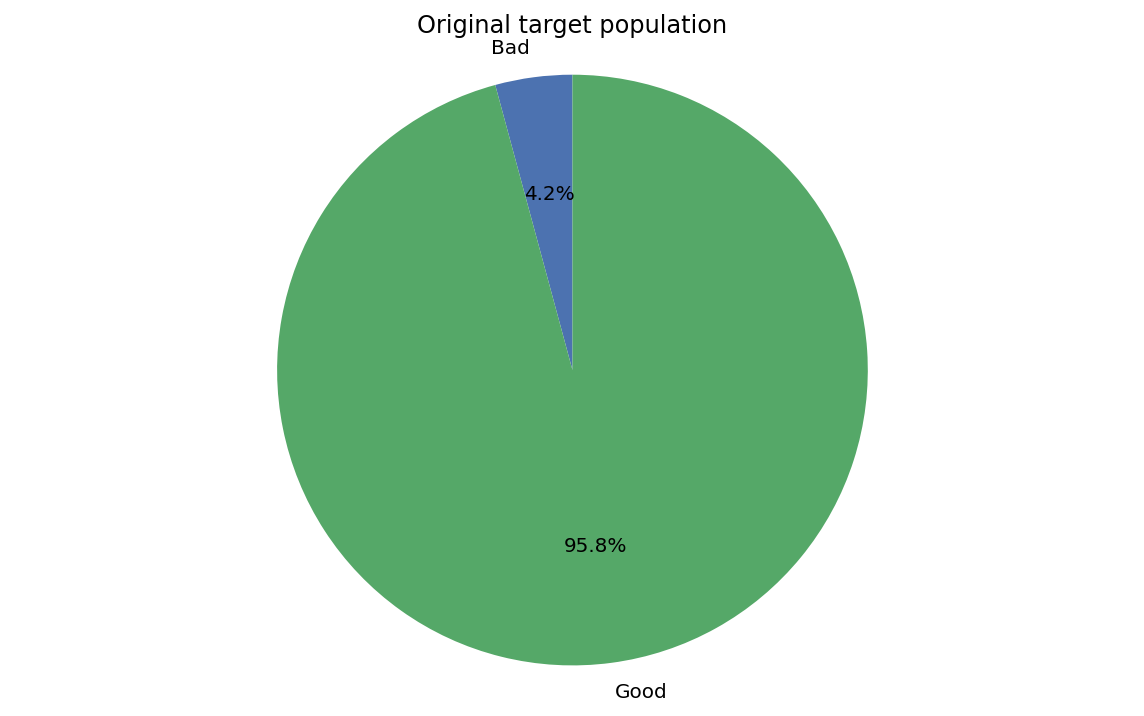

In [7]:
# Define plot function
def plotTarget(data, title):
  plt.figure(figsize = (10, 6))
  plt.title(title)
  plt.pie(
      [
      data['everDefault6'].sum(),
      data['everDefault6'].count() - data['everDefault6'].sum()
      ],
      labels = ['Bad', 'Good'],
      autopct = '%1.1f%%',
      startangle = 90
  )
  plt.axis('equal')
  return plt.show()

# Plot original target
plotTarget(df, 'Original target population')

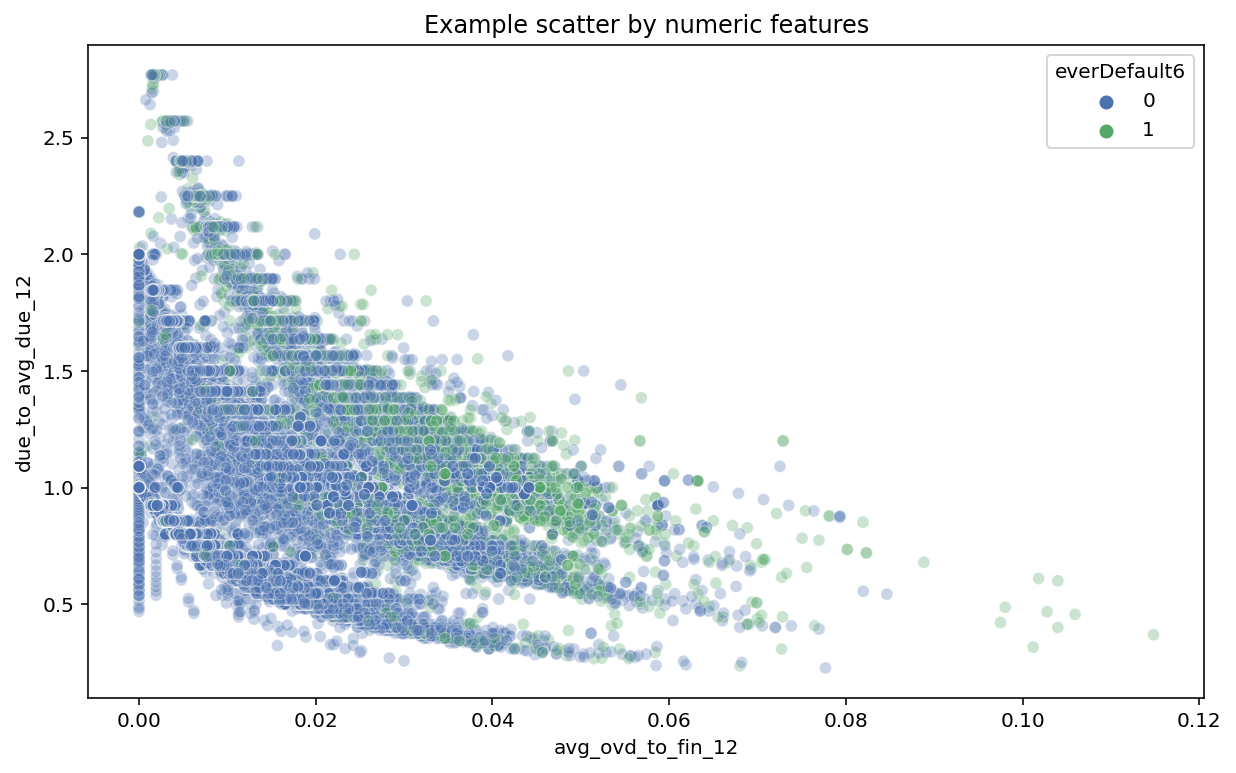

In [8]:
# Define plot features function
def plotFeature(data, title, x, y):
  plt.figure(figsize = (10, 6))
  plt.title(title)
  sns.scatterplot(
      data = data,
      x = x,
      y = y,
      hue = 'everDefault6',
      alpha = 0.3
  )
  return plt.show()

# Plot by example numeric features
plotFeature(df, 'Example scatter by numeric features', 'avg_ovd_to_fin_12', 'due_to_avg_due_12')

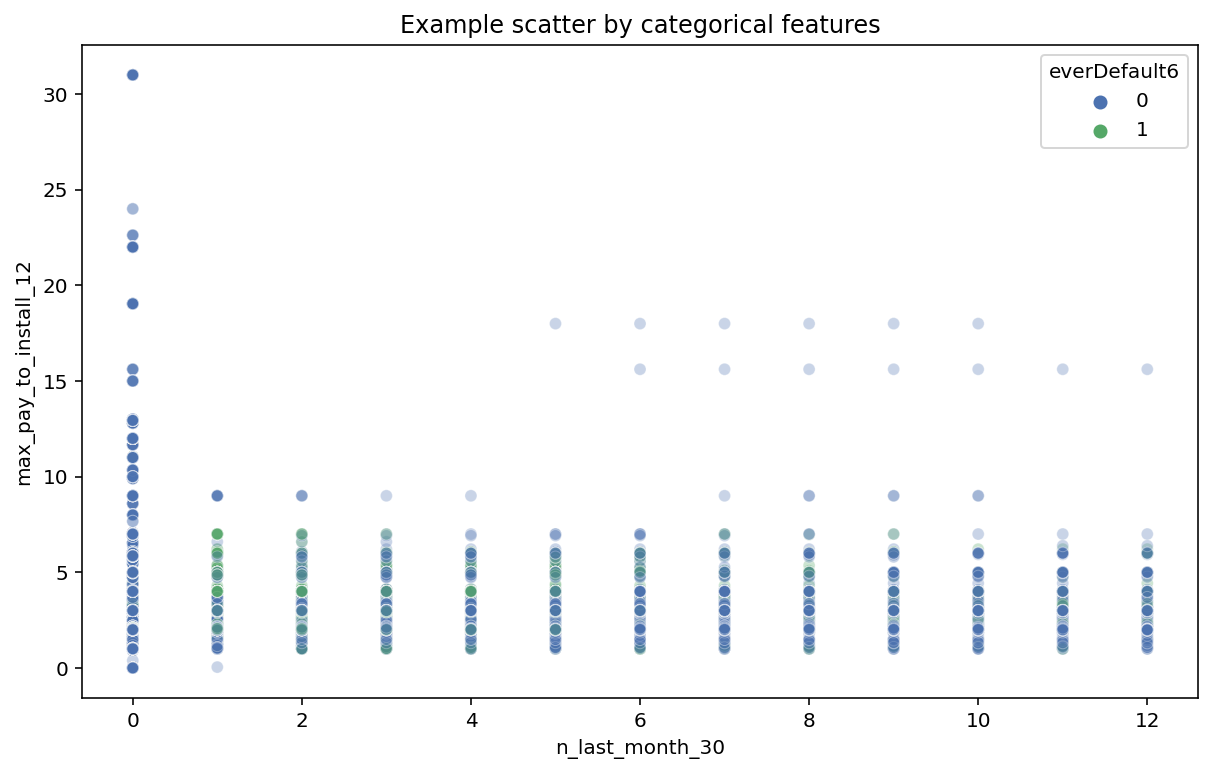

In [9]:
# Plot by example categorical features
plotFeature(df, 'Example scatter by categorical features', 'n_last_month_30', 'max_pay_to_install_12')

In [10]:
# Features and target data
X, y = df[allFeatures], df['everDefault6']

In [11]:
# Show total target
counter = Counter(y)
print(f'Normal cases: {counter[0]}\nDefault cases: {counter[1]}')

Normal cases: 280520
Default cases: 12331


In [12]:
# SMOTE Sampling
overSampling = SMOTENC(
    categorical_features = [5, 6], #Pass indices of categorical features
    n_jobs = -1
) #By default is set to equal target
XNew, yNew = overSampling.fit_resample(X, y)

In [13]:
# Show total target
counter = Counter(yNew)
print(f'Normal cases: {counter[0]}\nDefault cases: {counter[1]}')

Normal cases: 280520
Default cases: 280520


In [14]:
# To DataFrame
dfNew = pd.concat(
    [pd.DataFrame(
        XNew,
        columns = X.columns
    ),
     pd.Series(
         yNew,
         name = 'everDefault6'
     )],
     axis = 1
)

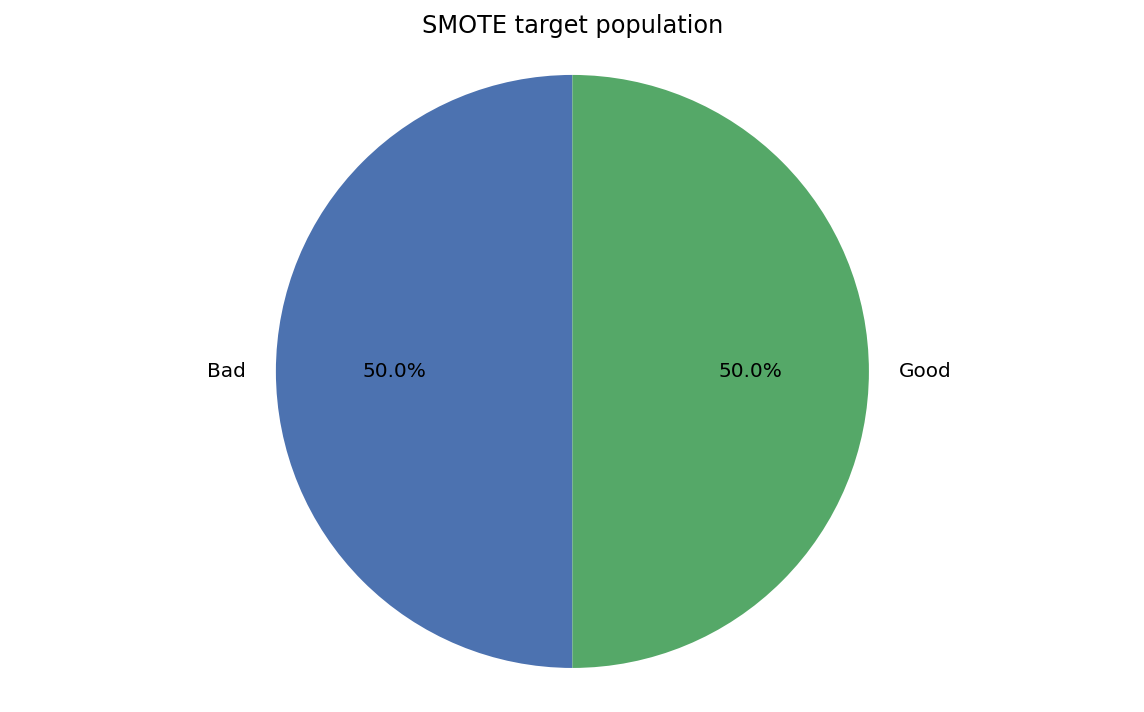

In [15]:
# Plot SMOTE Target
plotTarget(dfNew, 'SMOTE target population')

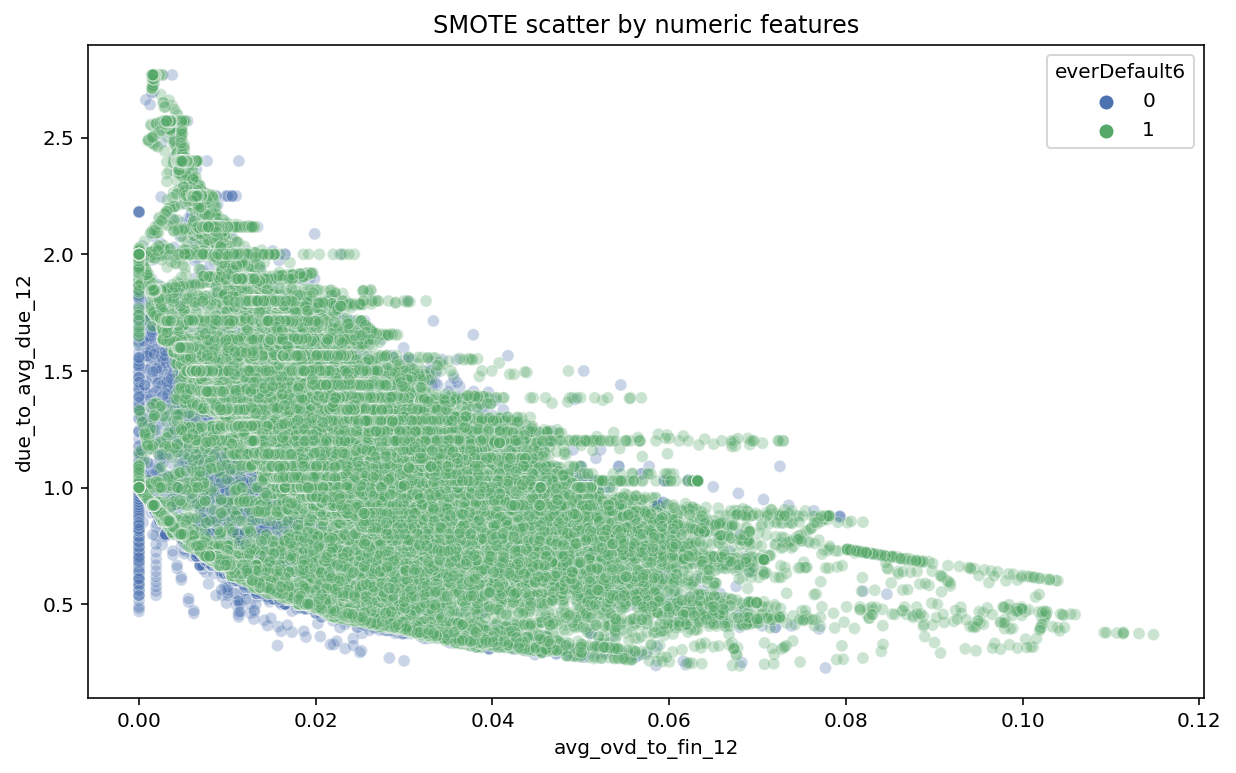

In [16]:
# Plot by SMOTE numeric features
plotFeature(dfNew, 'SMOTE scatter by numeric features', 'avg_ovd_to_fin_12', 'due_to_avg_due_12')

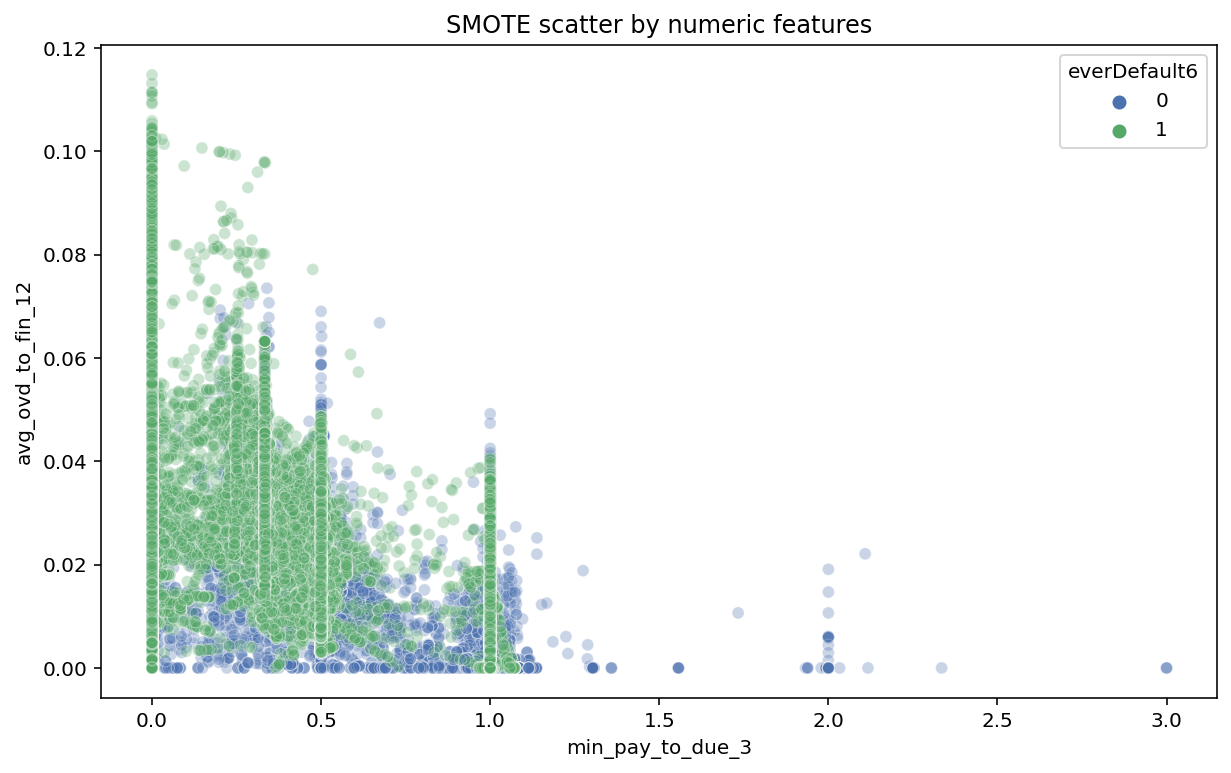

In [17]:
# Plot by SMOTE numeric features
plotFeature(dfNew, 'SMOTE scatter by numeric features', 'min_pay_to_due_3', 'avg_ovd_to_fin_12')

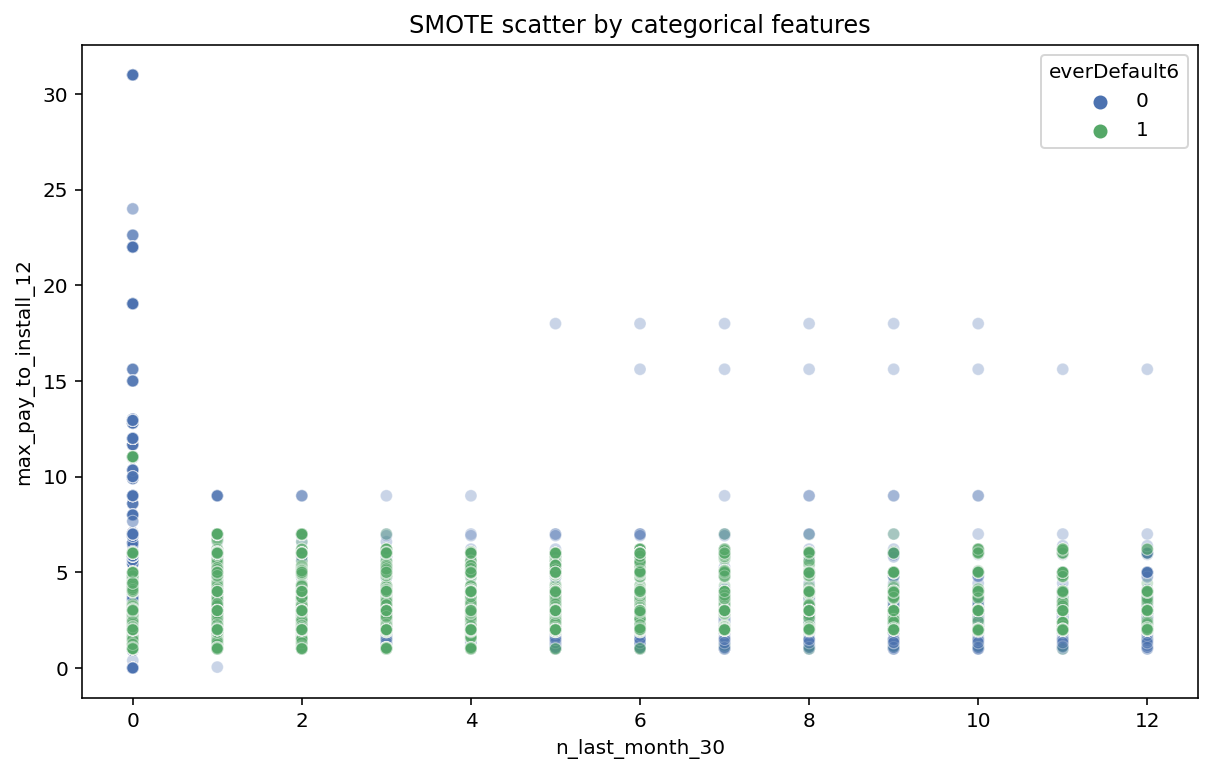

In [18]:
# Plot by SMOTE categorical features
plotFeature(dfNew, 'SMOTE scatter by categorical features', 'n_last_month_30', 'max_pay_to_install_12')

In [19]:
# Export
dfNew.to_parquet(
    'trainTransactionSMOTE.parquet',
    engine = 'pyarrow'
)